In [60]:
from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem
from scipy.stats import pearsonr
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool

import random

# import clsar package
import sys, os
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

from clsar.model.loss import ACALoss, get_best_cliff
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility  # model

from clsar.model.saver import SaveBestModel
from clsar.feature import Gen39AtomFeatures  # feature
from clsar.dataset import LSSNS  # dataset
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=2)

In [61]:
dataset_name = 'CHEMBL2835_Ki'
emb_path = '../../emb_results_1000/%s/embedding_prediction.pkl' % dataset_name

In [62]:
df = pd.read_csv(emb_path, index_col = 0)

In [63]:
group = 'train'
df1 = df[df.group == group]
dfm = pd.read_csv('./results_tmap/chemical_space_%s_new.csv' % group, index_col = 'smiles')
aca = df1[df1.with_aca == 'wi_aca']
noaca = df1[df1.with_aca == 'wo_aca']

df2 = aca

In [64]:
embeddings = df2[df2.columns[:512]].values
y = df2.y.values
predictions = df2.pred.values
smiles_list = df2.smiles.tolist()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

spread = 30
metric = 'cosine'
#u = UMAP(random_state = 42, spread=spread, metric = metric)
u = PCA(n_components=2)
xy = u.fit_transform(embeddings)
dfs = pd.DataFrame(xy,columns= ['dim1','dim2'], index=smiles_list)

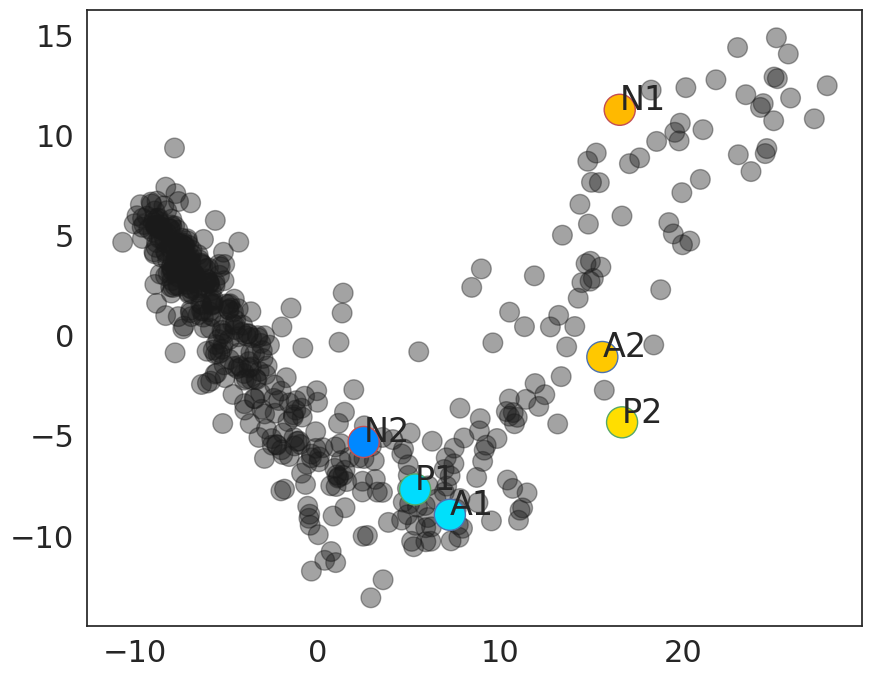

In [65]:
dfs['chemblid'] = dfs.index.map(dfm['chembl_id'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = 'k', alpha = 0.4, s = 200, edgecolors = dfs1.edgecolor)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)

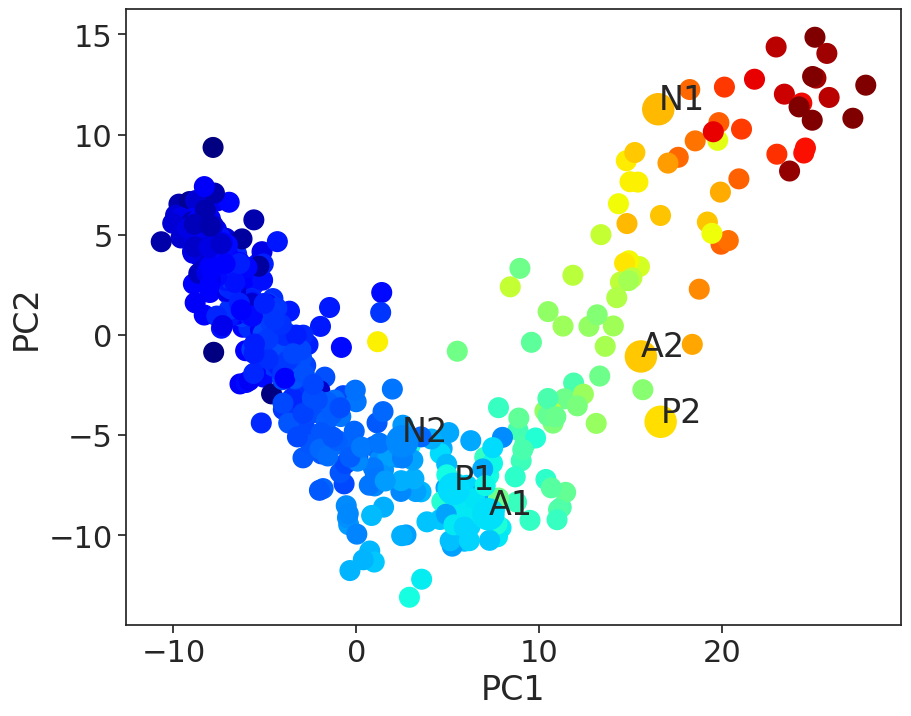

In [66]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = dfs1.node_color,s = 200,)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, )
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

fig.savefig('./results_pca/latent_sapce_with_ACA.pdf', dpi = 300, bbox_inches='tight')

In [67]:
x1 = (dfs1.dim1 < 20) & (dfs1.dim1 >15)
x2 = (dfs1.dim2 < 0) & (dfs1.dim2 >-5)
dfs1[x1 & x2].set_index('chemblid').true.sort_values()

chemblid
CHEMBL2392494    6.677781
CHEMBL2392501    7.602060
Name: true, dtype: float64

In [68]:
def label_incoherence_index(X, y, k=5):
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics.pairwise import cosine_distances

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    
    incoherence_values = []
    for i in range(X.shape[0]):
        neighbors_labels = y[indices[i, 1:]]
        local_incoherence = np.mean(np.abs(neighbors_labels - y[i]))
        incoherence_values.append(local_incoherence)
    return np.mean(incoherence_values)


In [69]:
lii = label_incoherence_index(embeddings, y)
print("基于模型（without-aca）隐空间的标签不连贯性:", lii)

基于模型（without-aca）隐空间的标签不连贯性: 0.19809592924335379


In [70]:
dim = 2048
from rdkit.Chem import AllChem
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
ecfps = np.array([list(fp) for fp in ECFP4_fps])

100%|###########################################################################################| 489/489 [00:00<00:00, 25719.66it/s]


In [71]:
lii = label_incoherence_index(ecfps, y)
print("基于结构ecfp的标签不连贯性:", lii)

基于结构ecfp的标签不连贯性: 0.37812214065439675


In [72]:
#dfs.to_csv('./results/latent_space_with_aca.csv')